### **Pothole Detection Project**
---
Project by Christian Dal Farra and Marco Panciera

#### **Project Overview**
This project implements a computer vision approach to detecting potholes in road surfaces using simple image processing techniques. The method is inspired by the article [Detecting Potholes Using Simple Image Processing Techniques and Real-World Footage](https://www.researchgate.net/publication/279538022_Detecting_Potholes_Using_Simple_Image_Processing_Techniques_and_Real-World_Footage) by Booysen et al.

Potholes pose a significant problem for road safety and infrastructure maintenance. This project aims to automate pothole detection from a vehicle-mounted camera by:

- **Defining a Region of Interest (ROI):** Extracting the relevant road section from each image to filter out unnecessary background elements.
- **Modeling Road Colors:** Calculating the mean and standard deviation of pixel values in the ROI to create a color-based road segmentation.
- **Edge Detection:** Applying the Canny edge detection algorithm to highlight potential potholes.
- **Morphological Operations:** Using dilation and contour detection to refine the detected pothole regions.
- **Pothole Segmentation:** Filtering and highlighting pothole contours based on size constraints to avoid false positives.

#### **High-Level Description**
The system processes real-world road images to isolate and detect potholes. The methodology follows these key steps:

1. **Image Preprocessing:** Resize and convert images to a standard format for consistency.
2. **ROI Selection:** Define a rectangular area to focus on the road while excluding distractions like the dashboard and sky.
3. **Road Color Modeling:** Estimate the average road color and its variations to distinguish road pixels from non-road areas.
4. **Edge and Contour Detection:** Apply Canny edge detection and contour extraction to identify potential potholes.
5. **Morphological Filtering:** Use dilation and size-based filtering to refine the detected potholes and remove noise.
6. **Final Visualization:** Overlay detected potholes onto the original image for verification.

![](presentation_images/algortihm_block_diagram.png)



#### **Environment Setup**
This project runs on **Python 3.12** and requires a virtual environment. To set up the environment and install dependencies, use the following commands:

```bash
python -m venv pothole_env
source pothole_env/bin/activate  # On Windows use `pothole_env\Scripts\activate`
pip install -r "requirements.txt"
```

### **1. Import Required Libraries**
This section imports the necessary libraries for image processing and visualization.  
- **OpenCV (cv):** Handles image manipulation, edge detection, and contour processing.  
- **NumPy (np):** Provides support for numerical computations and matrix operations.  
- **Matplotlib (plt):** Used for displaying images and intermediate processing steps. 

In [123]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

### **2. Define the Region of Interest (ROI)**
The **Region of Interest (ROI)** is the part of the image that contains the road and excludes unnecessary areas (e.g., dashboard, sky, road edges).  
- A **rectangle is drawn** over the ROI to visualize the area being analyzed.  
- The ROI is defined based on **x, y coordinates** that best represent the road area.  
- Multiple images are displayed with their ROIs to verify consistency.


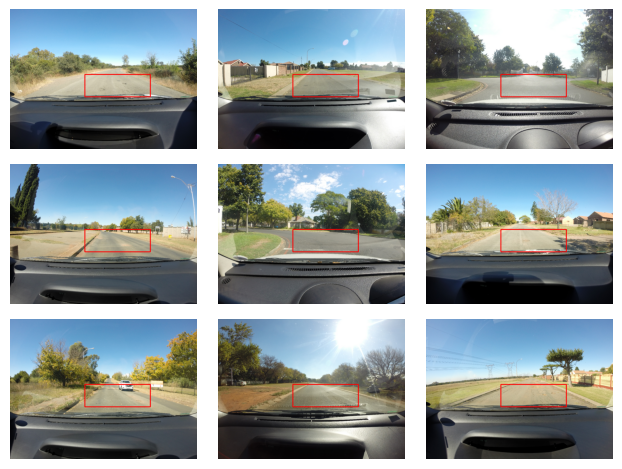

In [124]:
#this function draw a rectangle in the part of the image that we consider the ROI (Region Of Interest)
def draw_rect(image,roi_coords):
    output = cv.resize(image, (1000, 750))
    # Define the angles of the rectangle 
    # (x1, y1) -> top left corner
    # (x2, y2) -> bottom right corner
    start_point = (roi_coords[0], roi_coords[1])
    end_point = (roi_coords[2], roi_coords[3])
    color = (0, 0, 255)
    thickness = 3

    # draw on image
    cv.rectangle(output, start_point, end_point, color, thickness)
    return output

#Define the ROI, excluding lower part comprending the dashboard of the car, the upper part with the sky and the lateral parts
roi_coords = (400, 350, 750, 470) #(x1,y1,x2,y2)
_, axes = plt.subplots(3, 3)
axes[0,0].imshow(cv.cvtColor(draw_rect(cv.imread("test_images/test1.jpg"),roi_coords),cv.COLOR_BGR2RGB))
axes[1,0].imshow(cv.cvtColor(draw_rect(cv.imread("test_images/test2.jpg"),roi_coords),cv.COLOR_BGR2RGB))
axes[2,0].imshow(cv.cvtColor(draw_rect(cv.imread("test_images/test3.jpg"),roi_coords),cv.COLOR_BGR2RGB))
axes[0,1].imshow(cv.cvtColor(draw_rect(cv.imread("test_images/test4.jpg"),roi_coords),cv.COLOR_BGR2RGB))
axes[1,1].imshow(cv.cvtColor(draw_rect(cv.imread("test_images/test5.jpg"),roi_coords),cv.COLOR_BGR2RGB))
axes[2,1].imshow(cv.cvtColor(draw_rect(cv.imread("test_images/test6.jpg"),roi_coords),cv.COLOR_BGR2RGB))
axes[0,2].imshow(cv.cvtColor(draw_rect(cv.imread("test_images/test7.jpg"),roi_coords),cv.COLOR_BGR2RGB))
axes[1,2].imshow(cv.cvtColor(draw_rect(cv.imread("test_images/test8.jpg"),roi_coords),cv.COLOR_BGR2RGB))
axes[2,2].imshow(cv.cvtColor(draw_rect(cv.imread("test_images/test9.jpg"),roi_coords),cv.COLOR_BGR2RGB))

for ax in axes.flat: ax.axis('off')
plt.tight_layout()
plt.show()

### **3. Display the ROI for a Selected Image**
This section extracts the **ROI from a selected image** and displays it separately.  
- The **goal** is to focus the analysis on the relevant portion of the image.  
- The extracted area contains the **road surface** while filtering out **irrelevant background objects**. 

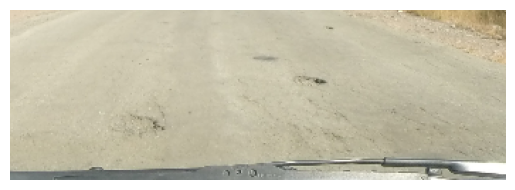

In [125]:
image = cv.imread("test_images/test1.jpg")
image = cv.resize(image, (1000,750))
image = cv.cvtColor(image,cv.COLOR_BGR2RGB)

# y1:y2 ,   x1:x2
roi = image[roi_coords[1]:roi_coords[3], roi_coords[0]:roi_coords[2]]
plt.axis('off')
plt.imshow(roi)

### **4. Compute the Mean and Standard Deviation of Colors in ROI**
To identify the road surface, the **mean color** and **standard deviation** of pixel values in the ROI are computed.  
- The **mean color** represents the average color of the road.  
- The **standard deviation** helps account for variations in lighting and road texture.  
- These values will be used to define a **color range** that distinguishes the road from other elements.

In [126]:
mean_color = np.mean(roi, axis=(0, 1))
std_color = np.std(roi, axis=(0, 1))

print(mean_color)
print(std_color)

[192.97111905 187.74780952 164.62559524]
[24.00601114 22.35439703 20.82967748]


### **5. Define the Road Color Range**
Using the **mean and standard deviation** values, a **color range** is defined:  
- **Lower Bound:** Removes overly dark pixels that might belong to shadows.  
- **Upper Bound:** Excludes excessively bright pixels (e.g., sunlight reflections).  
- The defined **range isolates road pixels**, allowing segmentation in the next steps.  
- **Visualization:**  
  - The lower bound, mean color, and upper bound are displayed as **color patches** for verification.

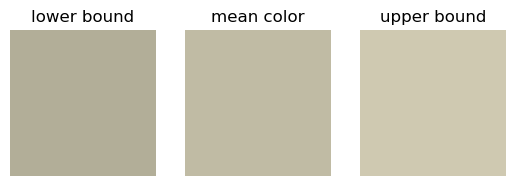

In [127]:
coef = 0.6

lower_bound=np.clip(mean_color - coef * std_color, 0, 255)
lower_bound_image = np.full((100, 100, 3), lower_bound, dtype=np.uint8)

upper_bound=np.clip(mean_color + coef * std_color, 0, 255)
upper_bound_image = np.full((100, 100, 3), upper_bound, dtype=np.uint8)

mean_color_image = np.full((100, 100, 3), mean_color, dtype=np.uint8)
_,axes=plt.subplots(1,3)
axes[0].imshow(lower_bound_image)
axes[0].set_title("lower bound")
axes[1].imshow(mean_color_image)
axes[1].set_title("mean color")
axes[2].imshow(upper_bound_image)
axes[2].set_title("upper bound")

for ax in axes: ax.axis('off')
plt.show()

### **6. Create a Binary Mask to Extract the Road**
A **binary mask** is generated to segment the road:  
- The mask highlights pixels **within the defined color range** while filtering out the background.  
- **Morphological operations** (closing and opening) are applied to:  
  - Fill small holes in the detected road.  
  - Remove small noise or scattered pixels.  
- **Canny edge detection** is applied to emphasize road boundaries.  
- The original image, mask, and edges are displayed side by side.


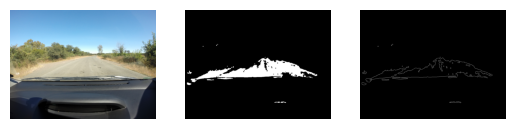

In [128]:
mask = cv.inRange(image, lower_bound, upper_bound)

#Apply morphological operations to clean up the mask
kernel = np.ones((4, 4), np.uint8)
mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)
mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)

# Apply Canny
edges = cv.Canny(mask, 50, 150)

# show the results
_, axes = plt.subplots(1,3)
axes[0].imshow(image)
axes[1].imshow(cv.cvtColor(mask,cv.COLOR_BGR2RGB))
axes[2].imshow(cv.cvtColor(edges,cv.COLOR_BGR2RGB))

for ax in axes: ax.axis('off')
plt.show()

### **7. Identify and Highlight Road Contours**
Contours are detected from the **binary road mask** to extract the road shape.  
- **Contours** are the boundaries of connected components (potential potholes or road sections).  
- A **convex hull** is computed for each contour to create a smooth approximation of the road.  
- The hulls are drawn on a black background to visualize the detected road area.


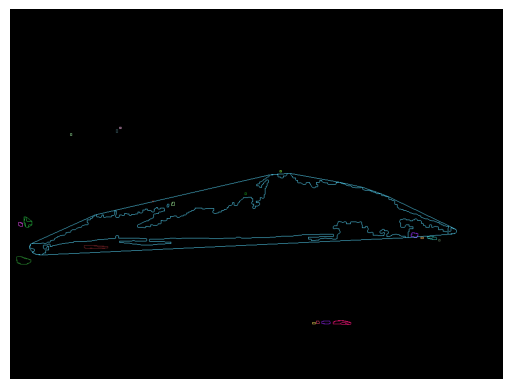

In [129]:
import random as rng
# Find contours
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Find the convex hull object for each contour
hull_list = []
for i in range(len(contours)):
        hull = cv.convexHull(contours[i])
        hull_list.append(hull)
# Draw contours + hull results
drawing = np.zeros((edges.shape[0], edges.shape[1], 3), dtype=np.uint8)
for i in range(len(contours)):
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        cv.drawContours(drawing, contours, i, color)
        cv.drawContours(drawing, hull_list, i, color)
# Show in a window
plt.axis('off')
plt.imshow(drawing)

### **8. Extract the Road Using the Convex Hull**
The **largest convex hull** (likely representing the road surface) is used to create a new mask.  
- The **road is segmented** by applying the mask to the original image.  
- This process **isolates the road from irrelevant regions** like trees, sidewalks, or parked cars.  
- The segmented road image is displayed for validation.


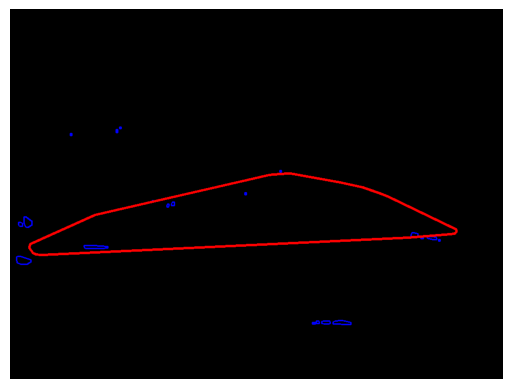

In [130]:
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Find the convex hull object for each contour
hull_list = [cv.convexHull(cnt) for cnt in contours]
# Draw contours + hull results
largest_hull = max(hull_list, key=cv.contourArea)
#print(largest_hull)
hull_segmentation = np.zeros((edges.shape[0], edges.shape[1], 3), dtype=np.uint8)
for hull in hull_list:
    cv.drawContours(hull_segmentation, [hull], -1, (0, 0, 255), 2)
# Draw the largest hull in green
cv.drawContours(hull_segmentation, [largest_hull], -1, (255, 0, 0), 3)
# Show in a window
plt.axis('off')
plt.imshow(hull_segmentation)

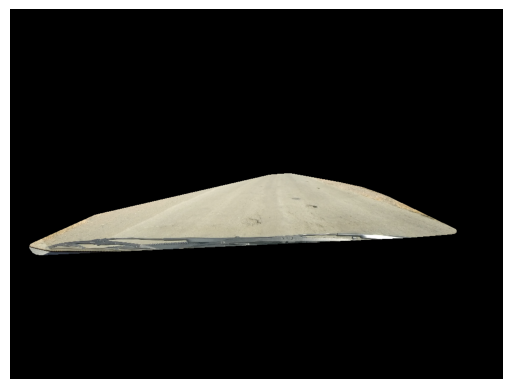

In [131]:
mask = np.zeros_like(cv.cvtColor(image, cv.COLOR_BGR2GRAY))

# draw the convex hull on the mask
cv.fillPoly(mask, [largest_hull], 255)

#Apply the mask on the test image
road_segmentation = cv.bitwise_and(image, image, mask=mask)
plt.axis('off')
plt.imshow(road_segmentation)

### **9. Convert Road Segmentation to Grayscale**
The **segmented road image** is converted to grayscale to simplify further processing.  
- This removes color information, reducing complexity for edge and pothole detection.  
- The grayscale representation highlights variations in road texture and potholes.


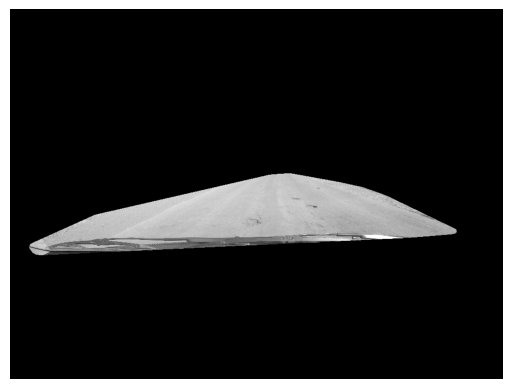

In [132]:
gray_road = cv.cvtColor(road_segmentation,cv.COLOR_RGB2GRAY)
plt.axis('off')
plt.imshow(gray_road,cmap='gray')

### **10. Apply Gaussian Blur**  
A **Gaussian blur** is applied to the grayscale image to:  
- **Reduce noise** and small irregularities in the road surface.  
- **Smooth intensity variations**, preventing false detections.  
- Preserve major edges, which are useful for detecting **pothole boundaries**. 

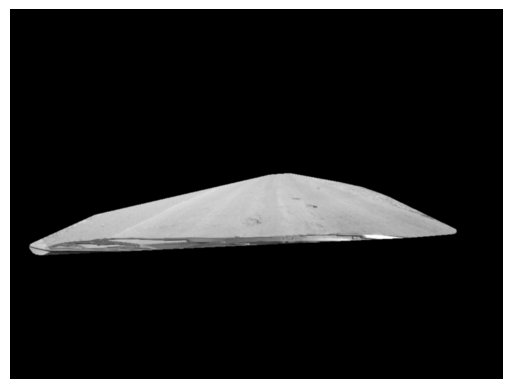

In [133]:
blur = cv.GaussianBlur(gray_road,(3,3),0)
plt.axis('off')
plt.imshow(blur,cmap='gray')

### **11. Detect Potholes Using Edge Detection and Contour Filtering**  
The **Canny edge detection** algorithm is used to highlight significant edges:  
- **Sharp intensity changes** (e.g., pothole edges) are detected.  
- A **dilation operation** enhances detected edges by connecting broken contours.  
- Contours are filtered based on **size constraints** to eliminate small cracks and noise.

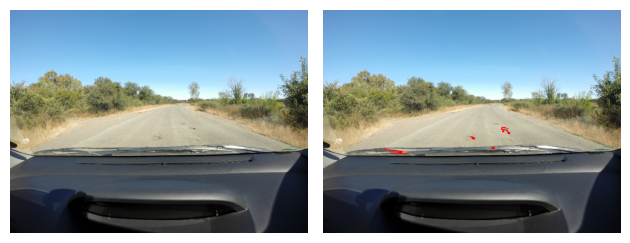

In [134]:
edges = cv.Canny(blur, 20, 150)
kernel = np.ones((5, 5), np.uint8)
dilated = cv.dilate(edges, kernel, iterations=5)
contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
max_size = 40
min_size = 20
potholes = [cnt for cnt in contours if max_size > cv.contourArea(cnt) > min_size]
output = image.copy()
cv.drawContours(output, potholes, -1, (255, 0, 0), 2)
output_resized = cv.resize(output, (1000, 750))
_, axes = plt.subplots(1, 2)
axes[0].imshow(image)
axes[1].imshow(output_resized)
for ax in axes.flat: ax.axis('off')
plt.tight_layout()
plt.show()

### **Conclusion**  
---
The pothole detection application successfully identifies road defects in many cases using image processing techniques. However, it still has limitations with certain images where potholes may not be detected correctly. Some of these issues arise due to variations in lighting, road textures, or image noise.  

Adjusting parameters such as the edge detection thresholds, morphological operations, or color segmentation bounds can sometimes improve performance. Further refinements, including more adaptive thresholding or advanced filtering techniques, could help enhance the detection accuracy across different road conditions.